In [111]:
# Library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cvxopt import solvers, matrix

In [112]:
# Environment setup
state_space = np.tile(np.arange(0, 100, 10), (10, 1)) + np.arange(0, 10, 1).reshape((10, 1))
discount_factor = 0.8
random_probability = 0.1

UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
all_actions = [UP, DOWN, LEFT, RIGHT]


def state_to_coordinate(state, state_sets=state_space):
    y, x = np.where(state_sets == state)
    return (x[0], y[0])

def coordinate_to_state(coordinate_x, coordinate_y, state_sets=state_space):
    return state_sets[coordinate_y, coordinate_x]

def get_valid_actions(state):
    valid_actions = all_actions.copy()
    x, y = state_to_coordinate(state)
    if x == 0:
        valid_actions.remove(LEFT)
    elif x == 9:
        valid_actions.remove(RIGHT)
    if y == 0:
        valid_actions.remove(UP)
    elif y == 9:
        valid_actions.remove(DOWN)
    return valid_actions

def get_next_states_probabilities(cur_state, cur_action):
    cur_valid_actions = get_valid_actions(cur_state)
    next_probabilities = [0] * 5 # Order UP, DOWN, LEFT, RIGHT, STAY
    for action in cur_valid_actions: # w/4 for states inside the grid
            next_probabilities[action] = random_probability / 4
    
    # Calculate the transition probabilities for an action
    if (len(cur_valid_actions) == 4): # No boundary cases
        next_probabilities[cur_action] += 1 - random_probability
        next_probabilities[4] = 0 # Probability to state in the current state is 0
    
    else: # With probability to move out the grid
        next_probabilities[4] = random_probability * (1 - len(cur_valid_actions) / 4)
        if cur_action in cur_valid_actions:
            next_probabilities[cur_action] += 1 - random_probability
        else:
            next_probabilities[4] += 1 - random_probability
    
    return next_probabilities

def state_reward(state, reward_function):
    x, y = state_to_coordinate(state)
    return reward_function[y, x]

def get_state_value_function(reward_function):
    # Initialize
    state_value_function = np.zeros((10, 10))
    delta = 1 # Exit flag

    while delta > 0.01:
        delta = 0 
        previous_state_value_function = state_value_function.copy()
        # Loop over 100 states
        for cur_state in range(100): 
            cur_x, cur_y = state_to_coordinate(cur_state)
            previous_state_value = previous_state_value_function[cur_y, cur_x]
            state_value_all_actions = [0] * 4

            # Loop over all actions
            for cur_action in all_actions:
                transition_probabilities = get_next_states_probabilities(cur_state, cur_action) 

                # Sum over one action
                for prob_idx in range(len(transition_probabilities)):
                    prob = transition_probabilities[prob_idx]
                    if (prob != 0): # Remove invalid case
                        # Next state coordinate
                        next_x = cur_x
                        next_y = cur_y
                        if prob_idx == 0: # Move up
                            next_y -= 1
                        elif prob_idx == 1: # Move down
                            next_y += 1
                        elif prob_idx == 2: # Move left
                            next_x -= 1
                        elif prob_idx == 3: # Move right
                            next_x += 1
                        else: # Stay in the state
                            pass
                        next_state = coordinate_to_state(next_x, next_y)
                        state_value_all_actions[cur_action] += prob * (state_reward(next_state, reward_function) + discount_factor * previous_state_value_function[next_y, next_x])

            cur_state_value = max(state_value_all_actions)
            state_value_function[cur_y, cur_x] = cur_state_value
            delta = max(delta, abs(previous_state_value - cur_state_value)) 
    return state_value_function

def get_optimal_policy_function(state_value_function, reward_function):
    # Initialize
    optimal_policy_function = np.zeros((10, 10))

    # Loop all states
    for cur_state in range(100):  
        cur_x, cur_y = state_to_coordinate(cur_state)
        state_value_all_actions = [0] * 4

        # Loop over all actions
        for cur_action in all_actions:
            transition_probabilities = get_next_states_probabilities(cur_state, cur_action) 

            # Sum over one action
            for prob_idx in range(len(transition_probabilities)):
                prob = transition_probabilities[prob_idx]
                if (prob != 0): # Remove invalid case
                    # Next state coordinate
                    next_x = cur_x
                    next_y = cur_y
                    if prob_idx == 0: # Move up
                        next_y -= 1
                    elif prob_idx == 1: # Move down
                        next_y += 1
                    elif prob_idx == 2: # Move left
                        next_x -= 1
                    elif prob_idx == 3: # Move right
                        next_x += 1
                    else: # Stay in the state
                        pass
                    next_state = coordinate_to_state(next_x, next_y)
                    state_value_all_actions[cur_action] += prob * (state_reward(next_state, reward_function) + discount_factor * state_value_function[next_y, next_x])
        
        #state_value_all_actions = np.around(state_value_all_actions, 3) # Round the value to 5 dicimal5
        optimal_action = np.argmax(state_value_all_actions)
        optimal_policy_function[cur_y, cur_x] = optimal_action
        #print('State: ', cur_state)
        #print(state_value_all_actions)
    return optimal_policy_function.astype(int)

def print_optimal_policy_with_arrows(optimal_policy_function):
    optimal_policy_symbols = np.chararray((10, 10), unicode=True)
    arrow_symbols = ['⇧','⇩','⇦','⇨']
#     arrow_symbols = ['↑ ','↓ ','←','→ ']
#     arrow_symbols = ['\21E1','\u21E3','\u21E0','\u21E2']
    for i in range(4):
        optimal_policy_symbols[optimal_policy_function == i] = arrow_symbols[i]
    print(pd.DataFrame(optimal_policy_symbols))

def plot_heat_map(heat_array, title):
    min_value = np.min(heat_array)
    max_value = np.max(heat_array)
    plt.pcolor(heat_array, cmap='hot',vmin=min_value, vmax=max_value)
    plt.ylim(top=0, bottom=10)
    plt.xlim(left=0, right=10)
    plt.colorbar()
    plt.title(title)
    plt.show()


Text(0.5,1,'reward_function_2')

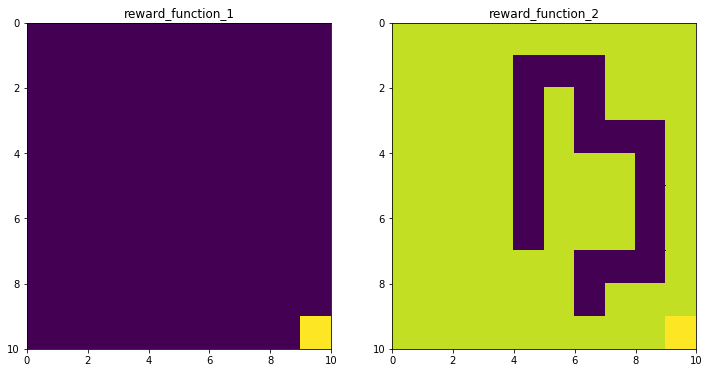

In [113]:
reward_function_1 = np.zeros((10,10))
reward_function_1[-1,-1] = 1


reward_function_2 = reward_function_1.copy()
locs = [(1,4),(2,4),(3,4),(4,4),(5,4),
           (6,4),(1,5),(1,6),(2,6),(3,6),
           (3,7),(3,8),(4,8),(5,8),(6,8),
           (7,8),(7,6),(7,7),(8,6)]

reward_function_2[-1,-1] = 10
for loc in locs:
    reward_function_2[loc] = -100
    
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].set_ylim(bottom=10, top=0)
ax[0].pcolor(reward_function_1)
ax[0].set_title('reward_function_1')
ax[1].set_ylim(bottom=10, top=0)
ax[1].pcolor(reward_function_2)
ax[1].set_title('reward_function_2')

In [114]:
optimal_policy_function_1 = np.array([[3, 3, 3, 3, 3, 3, 3, 3, 1, 1],
                                   [1, 1, 3, 3, 3, 3, 1, 1, 1, 1],
                                   [1, 1, 3, 3, 3, 1, 1, 1, 1, 1],
                                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                                   [1, 1, 1, 3, 3, 1, 1, 1, 1, 1],
                                   [1, 1, 3, 3, 3, 1, 1, 1, 1, 1],
                                   [1, 3, 3, 3, 3, 3, 1, 1, 1, 1],
                                   [1, 3, 3, 3, 3, 3, 3, 1, 1, 1],
                                   [3, 3, 3, 3, 3, 3, 3, 3, 1, 1],
                                   [3, 3, 3, 3, 3, 3, 3, 3, 3, 1]])

optimal_policy_function_2 = np.array([[1, 1, 1, 2, 2, 3, 3, 3, 3, 1],
                                   [1, 1, 1, 2, 2, 0, 3, 3, 3, 1],
                                   [1, 1, 1, 2, 2, 1, 3, 3, 3, 1],
                                   [1, 1, 1, 2, 2, 1, 1, 0, 3, 1],
                                   [1, 1, 1, 2, 2, 1, 1, 1, 3, 1],
                                   [1, 1, 1, 2, 2, 1, 1, 2, 3, 1],
                                   [1, 1, 1, 1, 1, 1, 2, 2, 3, 1],
                                   [1, 1, 1, 1, 1, 1, 2, 1, 1, 1],
                                   [3, 3, 3, 1, 1, 1, 1, 1, 1, 1],
                                   [3, 3, 3, 3, 3, 3, 3, 3, 3, 1]])

# print_optimal_policy_with_arrows(optimal_policy_function_1)
# print_optimal_policy_with_arrows(optimal_policy_function_2)

   0  1  2  3  4  5  6  7  8  9
0  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩
1  ⇩  ⇩  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩
2  ⇩  ⇩  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩
3  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩
4  ⇩  ⇩  ⇩  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩
5  ⇩  ⇩  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩
6  ⇩  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩
7  ⇩  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩
8  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩  ⇩
9  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩
   0  1  2  3  4  5  6  7  8  9
0  ⇩  ⇩  ⇩  ⇦  ⇦  ⇨  ⇨  ⇨  ⇨  ⇩
1  ⇩  ⇩  ⇩  ⇦  ⇦  ⇧  ⇨  ⇨  ⇨  ⇩
2  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇨  ⇨  ⇨  ⇩
3  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇧  ⇨  ⇩
4  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇩  ⇨  ⇩
5  ⇩  ⇩  ⇩  ⇦  ⇦  ⇩  ⇩  ⇦  ⇨  ⇩
6  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇦  ⇦  ⇨  ⇩
7  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇦  ⇩  ⇩  ⇩
8  ⇨  ⇨  ⇨  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩  ⇩
9  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇨  ⇩


In [127]:
def get_prob(s,policy_act,w=0.1):
    
    actions = [-10,+10,-1,+1,0]# action = [up,down,left,right,self]
    p_temp = np.zeros(5)# action = [up,down,left,right，self]

    # preset the random
    p_temp[2] = 0 if s%10 == 0 else w/4 # left
    p_temp[3] = 0 if (s+1)%10 == 0 else w/4 # right
    p_temp[0] = 0 if s-10 <= 0 else w/4 #up
    p_temp[1] = 0 if s+10 >= 100 else w/4 #bot
    p_temp[-1] = w-sum(p_temp[0:4]) #self
    
    p = p_temp.copy()
    if p_temp[policy_act] != 0:
        p[policy_act] += 1-w # move in one direction
    else:
        p[-1] += 1-w # return to self
    transition_row = np.zeros((1,100))
    for j,a in enumerate(actions):
        if p[j] != 0 :#and s+a in range(100):
            transition_row[0][s+a] = p[j]
    return transition_row

def get_transition_matrix(policy):
    transition_matrix = np.zeros((100,100))
    policy = policy.reshape((1,100))[0]
    for idx,policy_act in enumerate(policy):
        transition_matrix[idx] = get_prob(idx,policy_act)
    return transition_matrix

def get_transition_matrix_under_same_act(a):
    transition_matrix = np.zeros((100,100))
    
    for idx in range(100):
        transition_matrix[idx] = get_prob(idx,a)
    return transition_matrix

# (Pa* -Pa)(I-gamma*Pa*)^-1
def T(a,s,policy):
    policy = policy.reshape((1,100))
    policy_act = policy[0][s]
    return np.dot(get_prob(s,policy_act)-get_prob(s,a),
                 np.linalg.inv(np.eye(100)-
                 0.8*get_transition_matrix_under_same_act(policy_act)))
                
def get_accuracy(IRL_policy, true_policy):
    return np.sum(IRL_policy == true_policy) / 100

In [128]:
%%capture

discount_factor = 0.8
cur_reward = reward_function_2
Rmax = np.amax(np.abs(cur_reward))
cur_policy = optimal_policy_function_2


# D 
T_stack = np.vstack([
    -T(a, s, cur_policy)
    for s in range(100)
    for a in {0,1,2,3} - {cur_policy.reshape(1,-1)[0,s]} # remove the opt action
])

I_stack1 = np.vstack([
    np.eye(1, 100, s)
    for s in range(100)
    for a in {0,1,2,3} - {cur_policy.reshape(1,-1)[0,s]} # remove the opt action
])

I_stack2 = np.eye(100)
zero_stack1 = np.zeros((300, 100))
zero_stack2 = np.zeros((100, 100))


D_left = np.vstack([T_stack, T_stack, -I_stack2, I_stack2, -I_stack2,I_stack2])
D_middle = np.vstack([I_stack1, zero_stack1, zero_stack2, zero_stack2, zero_stack2,zero_stack2])
D_right = np.vstack([zero_stack1, zero_stack1, -I_stack2, -I_stack2, zero_stack2,zero_stack2])
D = np.hstack([D_left, D_middle, D_right])

# b
b = (np.concatenate((np.zeros(800), Rmax * np.ones(200))))

# CVXopt
G = matrix(D)
h = matrix(b)

# All accuracies
all_acc = list()
IRL_best_penalty = 0
IRL_best_reward = 0
IRL_optimal_state_values = 0
IRL_optimal_policy = 0

# Solve LP with muptiple penalty factors
for penalty_factor in np.arange(0, 5.01, 0.01):
    c = matrix(-np.concatenate((np.zeros(100), np.ones(100), np.ones(100) * (-penalty_factor))))
    sol = solvers.lp(c, G, h)
    IRL_reward = np.array(sol['x'][0:100]).reshape(10, 10).T
    IRL_state_values = get_state_value_function(IRL_reward)
    IRL_policy = get_optimal_policy_function(IRL_state_values, IRL_reward)
    accuracy = get_accuracy(IRL_policy, cur_policy)
    # Store the best results
    if (len(all_acc) == 0 or accuracy > max(all_acc)):
        IRL_best_penalty = penalty_factor
        IRL_best_reward = IRL_reward
        IRL_optimal_state_values = IRL_state_values
        IRL_optimal_policy = IRL_policy
    all_acc.append(accuracy)

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (501,) and (7,)

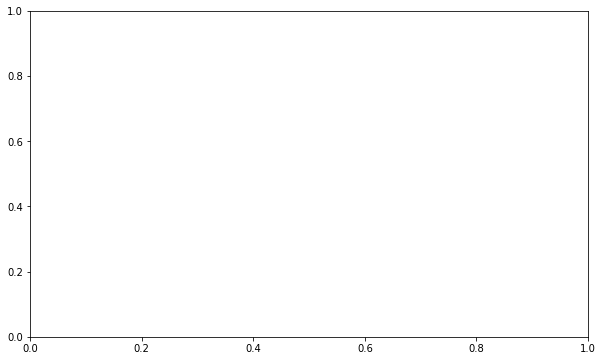

In [129]:
# plot the accuracy and penalty
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 5.01, 0.01), all_acc)
plt.xlabel('Penalty Factor')
plt.ylabel('Accuracy')
plt.title('Accuracy VS Penalty Factor')
plt.show()

print('Penalty factor with best accuracy: ', IRL_best_penalty)
print('Corresponding accuracy: ', np.max(all_acc))
plot_heat_map(cur_reward, 'Heat map of the ground truth reward')
plot_heat_map(IRL_best_reward, 'Heat map of the extracted reward')
plot_heat_map(IRL_optimal_state_values, 'Heat map of the optimal state values')
print_optimal_policy_with_arrows(IRL_optimal_policy)
